## Keras implementation of https://phillipi.github.io/pix2pix

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # can choose theano, tensorflow, cntk
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile,dnn.library_path=/usr/lib'

In [2]:
import keras.backend as K
if os.environ['KERAS_BACKEND'] =='theano':
    channel_axis=1
    K.set_image_data_format('channels_first')
    channel_first = True
else:
    K.set_image_data_format('channels_last')
    channel_axis=-1
    channel_first = False

Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

In [4]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization


In [5]:
# HACK speed up theano
if K._BACKEND == 'theano':
    import keras.backend.theano_backend as theano_backend
    def _preprocess_conv2d_kernel(kernel, data_format):
        #return kernel
        if hasattr(kernel, "original"):
            print("use original")
            return kernel.original
        elif hasattr(kernel, '_keras_shape'):
            s = kernel._keras_shape
            print("use reshape",s)
            kernel = kernel.reshape((s[3], s[2],s[0], s[1]))
        else:
            kernel = kernel.dimshuffle((3, 2, 0, 1))
        return kernel
    theano_backend._preprocess_conv2d_kernel = _preprocess_conv2d_kernel

In [6]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, nc_out, ndf, max_layers=3):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a, input_b =  Input(shape=(nc_in, None, None)), Input(shape=(nc_out, None, None))
    else:
        input_a, input_b = Input(shape=(None, None, nc_in)), Input(shape=(None, None, nc_out))
    _ = Concatenate(axis=channel_axis)([input_a, input_b])
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid") (_)    
    return Model(inputs=[input_a, input_b], outputs=_)

In [7]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [8]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
λ = 10

loadSize = 286
imageSize = 256
batchSize = 1
lrD = 2e-4
lrG = 2e-4

In [9]:
netD = BASIC_D(nc_in, nc_out, ndf)
netD.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, None, None, 6) 0           input_1[0][0]                    
                                                                   input_2[0][0]                    
____________________________________________________________________________________________________
First (Conv2D)                   (None, None, None, 64 6208        concatenate_1[0][0]     

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


netG = UNET_G(imageSize, nc_in, nc_out, ngf)
#SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))
netG.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv_256 (Conv2D)                (None, 128, 128, 64)  3136        input_3[0][0]                    
____________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)        (None, 128, 128, 64)  0           conv_256[0][0]                   
____________________________________________________________________________________________________
conv_128 (Conv2D)                (None, 64, 64, 128)   131072      leaky_re_lu_5[0][0]              
___________________________________________________________________________________________

In [11]:
from keras.optimizers import RMSprop, SGD, Adam

In [12]:
real_A = netG.input
fake_B = netG.output
netG_generate = K.function([real_A], [fake_B])
real_B = netD.inputs[1]
output_D_real = netD([real_A, real_B])
output_D_fake = netD([real_A, fake_B])

In [13]:
#loss_fn = lambda output, target : K.mean(K.binary_crossentropy(output, target))
loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

loss_D_real = loss_fn(output_D_real, K.ones_like(output_D_real))
loss_D_fake = loss_fn(output_D_fake, K.zeros_like(output_D_fake))
loss_G_fake = loss_fn(output_D_fake, K.ones_like(output_D_fake))


loss_L1 = K.mean(K.abs(fake_B-real_B))

In [14]:
loss_D = loss_D_real +loss_D_fake
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(netD.trainable_weights,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_D/2], training_updates)

In [15]:
loss_G = loss_G_fake   #+ 100 * loss_L1
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(netG.trainable_weights,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_G_fake, loss_L1], training_updates)



In [16]:
from PIL import Image, ImageDraw
import numpy as np
import glob
from random import randint, shuffle
from math import pi
from random import randint

def read_image():
    r = randint(imageSize//10,imageSize//5)
    x = randint(imageSize//4, imageSize*3//4)
    y = randint(imageSize//4, imageSize*3//4)
    color = (randint(128,255), randint(128,255), randint(128,255))
    im = Image.new('RGB', (imageSize, imageSize), (0,0,0))
    draw = ImageDraw.Draw(im)
    draw.ellipse([x-r, y-r, x+r, y+r], fill=color)
    imgA = np.array(im)/255*2-1
    
    im = Image.new('RGB', (imageSize, imageSize), (0,0,0))    
    draw = ImageDraw.Draw(im)    
    l = pi**0.5 * r /2
    if randint(0,1):
        l*=2**0.5
        draw.polygon([x, y-l, x+l, y, x,y+l, x-l,y], fill=color)
    else:
        draw.rectangle([x-l, y-l, x+l, y+l], fill=color)
    imgB = np.array(im)/255*2-1

    if channel_first:
        imgA = np.moveaxis(imgA, 2, 0)
        imgB = np.moveaxis(imgB, 2, 0)
    return imgA, imgB


In [17]:
def minibatch(batchsize):
    length = 10000
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:            
            i = 0
            epoch+=1        
        dataA = []
        dataB = []
        for j in range(i,i+size):
            imgA,imgB = read_image()
            dataA.append(imgA)
            dataB.append(imgB)
        dataA = np.float32(dataA)
        dataB = np.float32(dataB)
        i+=size
        tmpsize = yield epoch, dataA, dataB        
        

In [18]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))

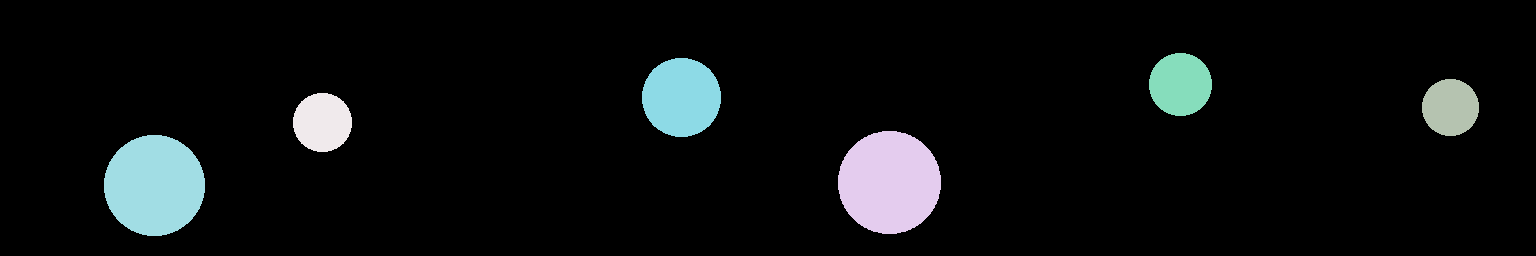

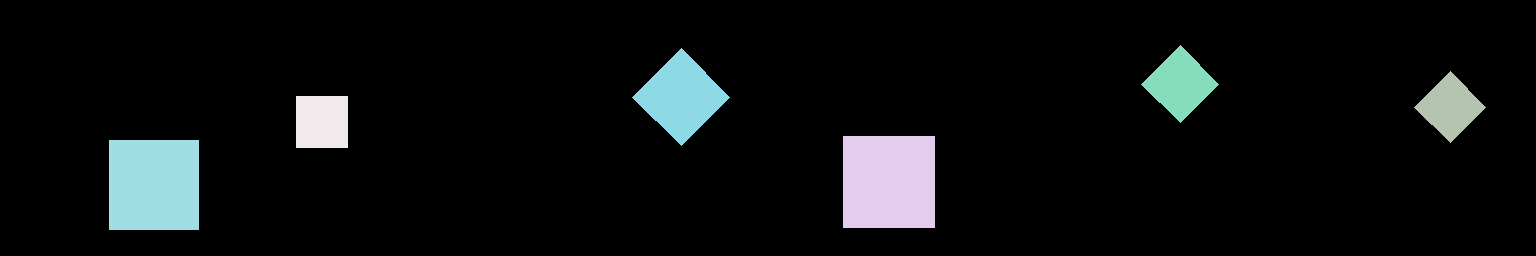

In [19]:
train_batch = minibatch(6)
_, trainA, trainB = next(train_batch)
showX(trainA)
showX(trainB)
del train_batch, trainA, trainB

In [20]:
def netG_gen(A):
    return np.concatenate([netG_generate([A[i:i+1]])[0] for i in range(A.shape[0])], axis=0)

[4/50][46500] Loss_D: 0.158638 Loss_G: 3.423243 loss_L1: 0.023366 10086.479277849197


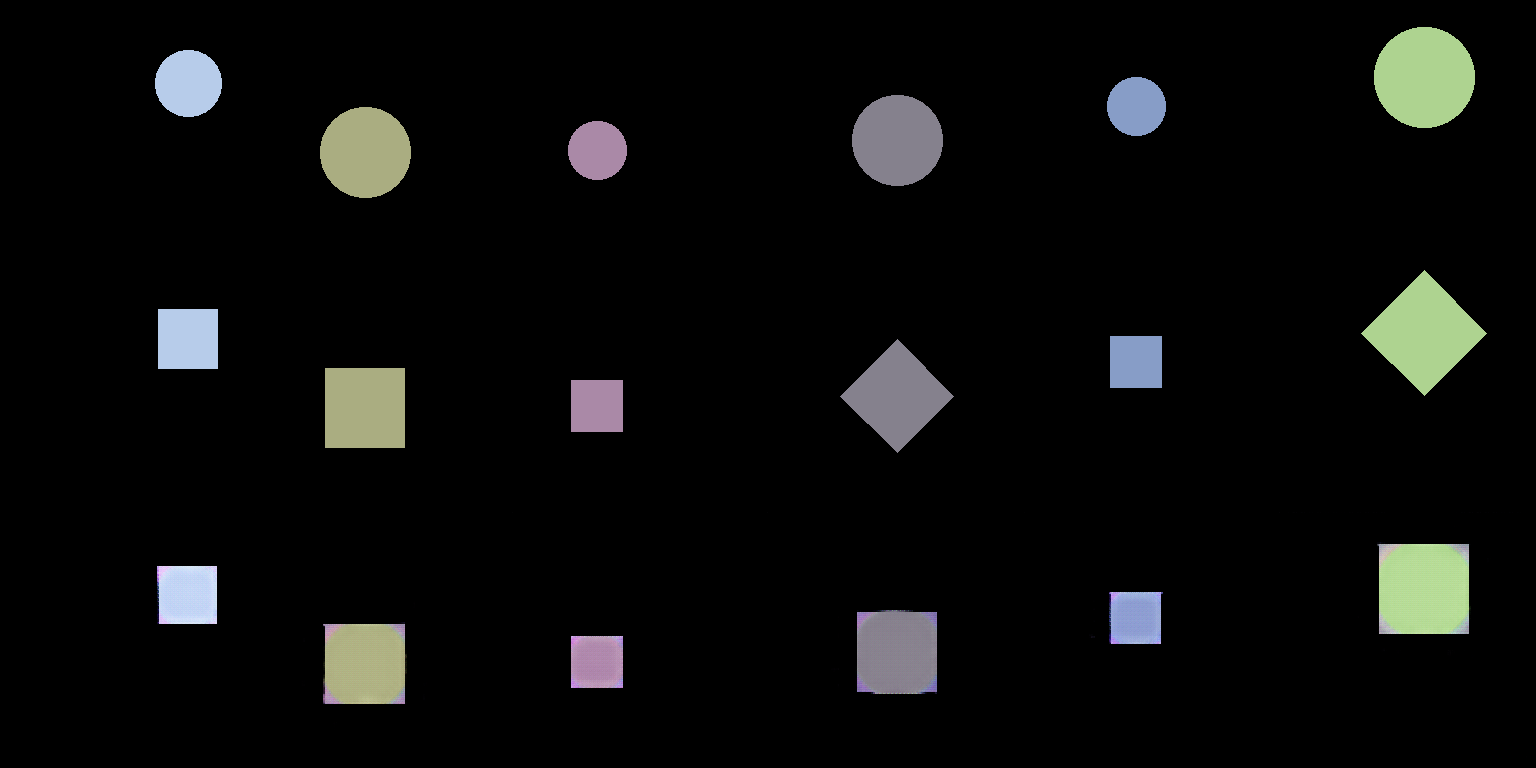

[4/50][46600] Loss_D: 0.134838 Loss_G: 3.483866 loss_L1: 0.024398 10108.749535560608


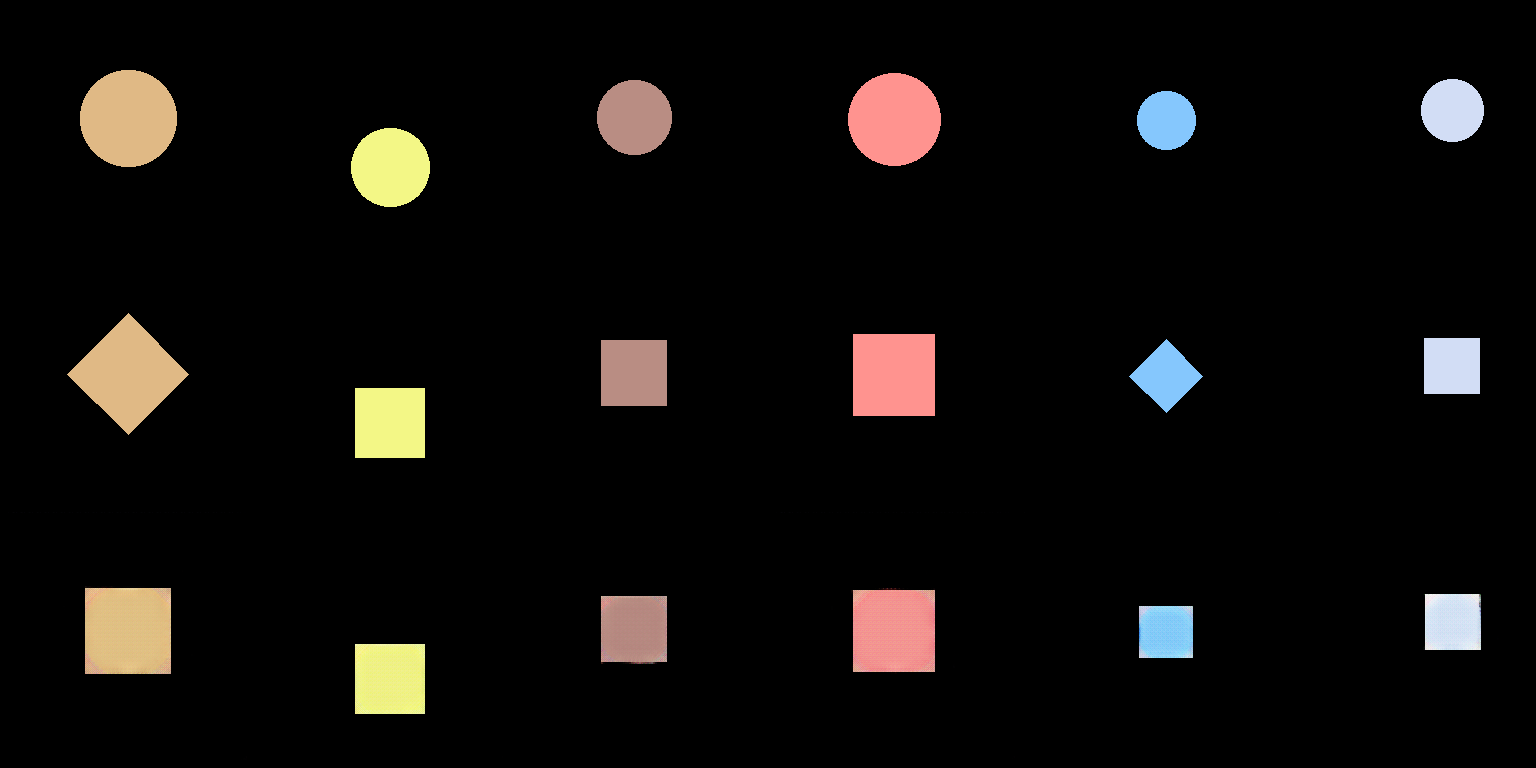

[4/50][46700] Loss_D: 0.140947 Loss_G: 3.509397 loss_L1: 0.024218 10130.781980514526


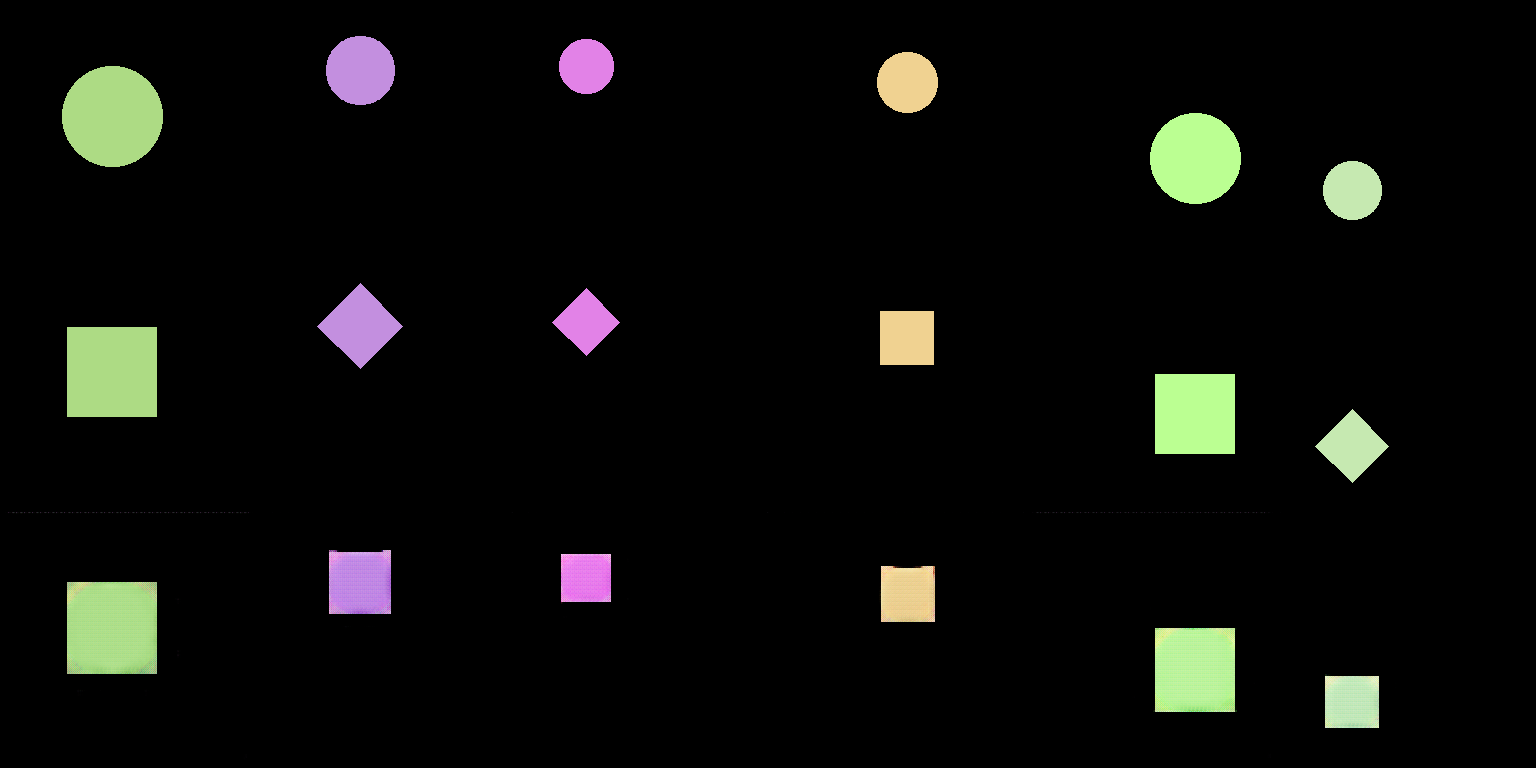

KeyboardInterrupt: 

In [21]:
import time
from IPython.display import clear_output
t0 = time.time()
niter = 50
gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

display_iters = 100
train_batch = minibatch(batchSize)

while epoch < niter: 
    epoch, trainA, trainB = next(train_batch)        
    errD,  = netD_train([trainA, trainB])
    errD_sum +=errD

    errG, errL1 = netG_train([trainA, trainB])
    errG_sum += errG
    errL1_sum += errL1
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        if gen_iterations%(5*display_iters)==0:
            clear_output()
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_L1: %f'
        % (epoch, niter, gen_iterations, errD_sum/display_iters, errG_sum/display_iters, errL1_sum/display_iters), time.time()-t0)
        _, valA, valB = train_batch.send(6) 
        fakeB = netG_gen(valA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        errL1_sum = errG_sum = errD_sum = 0        
        

In [ ]:
_, valA, valB = train_batch.send(6) 
fakeB = netG_gen(valA)
showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
